**01 -> Importing Standard Libraries**

In [21]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import transforms
from torchsummary import summary
import sys
import numpy as np
from collections import defaultdict
from collections import OrderedDict
from matplotlib import pyplot as plt
from PIL import Image

**02 -> Define Custom Libraies**






02.0 -> Define Constant

In [22]:
imgMean = [0.5, 0.5, 0.5]
imgStd = [0.5, 0.5, 0.5]

02.1 -> Common Utils

In [23]:
# Reverse the transformations to get back to a displayable image
def revertStandardizedImageTensor(img_tensor, imgMean, imgStd):

    # Reverse normalization
    for t, m, s in zip(img_tensor, imgMean, imgStd):
        t.mul_(s).add_(m)

    # Transpose channels (C, H, W) to (H, W, C)
    img_tensor = img_tensor.permute(1, 2, 0)

    # Convert to NumPy array and scale to 0-255
    img_numpy = img_tensor.detach().cpu().numpy()
    img_numpy = (img_numpy * 255).astype(np.uint8)

    # Convert to PIL Image
    pil_image = Image.fromarray(img_numpy)
    return pil_image

In [24]:
def plotImages_Dataset(dataset, class_label, nRows, nCols):
    n_classes  = len(class_label)
    cur_fig, cur_axes = plt.subplots(nRows, nCols, figsize=(30, 25))
    labelList = [item[1] for item in dataset]
    indList_UniqueClass = [labelList.index(i) for i in range(n_classes)]
    data = [dataset[idx] for idx in indList_UniqueClass]
    cur_axes = cur_axes.flatten()
    for cur_data, cur_ax in zip(data, cur_axes):
        img = cur_data[0]
        y = cur_data[1]
        # tensor data type has different data orientation
        # tensor:[channel, width, height] -> numpy_format: [width, height, channel]
        #img = img.permute(1, 2, 0)
        img = revertStandardizedImageTensor(img, imgMean, imgStd)
        cur_ax.imshow(img)
        cur_ax.set_title(str(y) + ' : ' + class_label[y])
        cur_ax.axis('off')
    cur_fig.suptitle('Sample Images for Each Labeled Classes', fontsize=28, fontweight='bold')
    plt.show()

In [25]:
def printInfo_DataLoader(cur_DataLoader, data_category, sep_len=50):
    print("="*sep_len)
    print(f">>>  {data_category}  <<<")
    total_num_samples = cur_DataLoader.dataset.__len__()
    total_num_batches = cur_DataLoader.__len__()
    print(f"Total Number of Samples: {total_num_samples}")
    print(f"Total Number of Batches: {total_num_batches}")
    for X, y in cur_DataLoader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}")
        break
    print("-"*sep_len)

02.2 -> Define VGG Model

In [26]:
# Define different VGG Architectures
VGG_Architectures = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M',256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}
# Available VGG architectures
vgg_types={0:'VGG11', 1:'VGG13', 2:'VGG16', 3:'VGG19'}

In [27]:
# Define Customize VGG model
class Custom_VGG(nn.Module):
  def __init__(self, vgg_type, in_channels=3, nClasses=100):
      super(Custom_VGG, self).__init__()
      self.architecture = VGG_Architectures[vgg_type]
      self.in_channels = in_channels
      self.VGG_Layers = self.build_VGG_Architectures()
      self.fc_block1 = nn.Sequential(
          nn.Flatten(),
          nn.Linear(512 * 7 * 7, 4096),
          nn.ReLU(),
          nn.Dropout(p=0.5),  # half of the weight will be zeros
          )

      self.fc_block2 = nn.Sequential(
          nn.Linear(4096, 4096),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          nn.Linear(4096, nClasses)
          )

  def forward(self, x):
      x = self.VGG_Layers(x)
      x = self.fc_block1(x)
      x = self.fc_block2(x)
      return x

  def build_VGG_Architectures(self):
      layers = []  # we can also use nn.ModuleList()
      # in_channel for the first layer
      in_channels = self.in_channels
      i = -1 # index to non max-layer
      j = -1 # index to max-layer
      for x in self.architecture:
          if type(x) == int:
            # handles non max-layers
            out_channels = x
            i = i + 1
            layer_Name = 'layer' + str(i)

            conv_Layer = nn.Conv2d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    kernel_size=(3, 3),
                                    stride=(1, 1),
                                    padding=(1, 1))
            batch_Layer = nn.BatchNorm2d(out_channels)
            relu_Layer = nn.ReLU()
            layers.append(('conv_' + layer_Name, conv_Layer))
            layers.append(('batchNorm_' + layer_Name, batch_Layer))
            layers.append(('relu_' + layer_Name, relu_Layer))
            # link current layer's out_channels to next layer's in_channels
            in_channels = out_channels
          else:
            # handles max layer
            j = j + 1
            layer_Name = 'layer' + str(j)
            max_Layer = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
            layers.append(('maxPool_' + layer_Name, max_Layer))

      return nn.Sequential(OrderedDict(layers))

02.3 -> Model Trainig Utils

In [28]:
# This is for batch accuracy
def get_accuracy(preds_vec, y):
    batch_size, _ = preds_vec.shape
    # Note: For tensor with one-dimension, then dim=-1 does nothing
    #       For tensor with [rows, cols], then dim=-1 refers to the cols dimension
    #       For tensor with [channel, rows, cols] then dim=-1 refers to the cols dimension
    # the current operation returns a index along the cols dimension
    predicted_classes = preds_vec.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(y).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [29]:
# Training (Note: Model need not to be return, all weights are updated within)
def train_model(train_dataloader, model, loss_fn, optimizer, device):
    total_num_of_batches = len(train_dataloader)
    total_num_of_samples = len(train_dataloader.dataset)

    zero_pad_width = int(np.ceil(np.log10(total_num_of_batches)))
    cur_total_samples = 0
    batch_loss_list = list()
    batch_acc_list = list()

    # Enable weight updates
    model.train()

    for batch, (X, y) in enumerate(train_dataloader):
        # X size [Batch, Channel, Width, Height]: (BatchSize, 1, 224, 224)
        # y size:(BatchSize, 1) -> second dimension is an integer value between 0 to 99
        X, y = X.to(device), y.to(device)
        cur_total_samples = cur_total_samples + X.shape[0]

        # Note: Forward-pass will automatically save gradients between nodes
        # Reset all gradient before loss computation
        optimizer.zero_grad()

        # Model prediction -> logits -> [Batch, numClasses]
        logits = model(X)

        # Compute prediction loss
        # logits and y needs to have same batches dimension,
        # but doesn't need to be the exact same tensor dimension
        batch_loss = loss_fn(logits, y)

        # Compute batch accuracy
        batch_acc = get_accuracy(logits, y)

        # Backpropagation with chain rule
        batch_loss.backward()

        # Update weights with current optimizer setting
        optimizer.step()

        batch_loss_list.append(batch_loss.item())
        batch_acc_list.append(batch_acc.item())

        if batch % 100 == 0 or batch == total_num_of_batches-1:
            batch_loss_value = batch_loss.item()
            # >7f -> right align with 7 characters with fixed floating points
            print(f"batch#: {str(batch).rjust(zero_pad_width,'0')} "
                  f"batch_loss: {batch_loss_value:>7f}  "
                  f"[{cur_total_samples:>5d}/{total_num_of_samples:>5d}]")

    epoch_loss = np.mean(batch_loss_list)
    epoch_acc = np.mean(batch_acc_list)
    return epoch_loss, epoch_acc

In [30]:
# Evaluation Stage
def evaluate(valid_dataloader, model, loss_fn, device):
    total_num_of_batches = len(valid_dataloader)
    total_num_of_samples = len(valid_dataloader.dataset)

    batch_loss_valid, batch_acc_valid = 0, 0

    batch_loss_list = []
    batch_acc_list = []

    # Model Eval will #1).deactivate updates for BatchNorm
    # and 2). disable Dropout usage
    model.eval()

    # While working with evaluation, deactivate autograd engine to
    # 1). reduce memory usage, 2). stop weight updates
    # and 3). speeds up computation
    with (torch.no_grad()):
        for X, y in valid_dataloader:
            X, y = X.to(device), y.to(device)
            # Model prediction -> [batch_size, class_size]
            logits = model(X)
            # Sum up all losses from each batch
            batch_loss_valid = loss_fn(logits, y)
            # Batch accuracy
            batch_acc_valid = get_accuracy(logits, y)

            batch_loss_list.append(batch_loss_valid.item())
            batch_acc_list.append(batch_acc_valid.item())
    epoch_loss = np.mean(batch_loss_list)
    epoch_acc = np.mean(batch_acc_list)
    return epoch_loss, epoch_acc

In [31]:
def train_model_under_n_epochs(train_dataloader, valid_dataloader,
                               epochs, model, loss_fn, optimizer, device):
    sep_len = 50
    best_valid_loss = np.inf
    model_train_loss = np.inf

    epoch_metrics = defaultdict(list)
    print(f"=" * sep_len)
    print(f" >>> Model Training with {epochs} epochs <<<")
    for epoch in range(epochs):
        print(f"epoch: {epoch}")
        train_loss, train_acc = train_model(train_dataloader, model, loss_fn, optimizer, device)
        valid_loss, valid_acc = evaluate(valid_dataloader, model, loss_fn, device)

        epoch_metrics['train_loss_list'].append(train_loss)
        epoch_metrics['train_acc_list'].append(train_acc)
        epoch_metrics['valid_loss_list'].append(valid_loss)
        epoch_metrics['valid_acc_list'].append(valid_acc)

        # Save only the best valid loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            model_train_loss = train_loss
            torch.save(model.state_dict(), "optimal_VGG_state_dict.pt")

        print(f"epoch {epoch}  -> training and validation results\n"
              f"train_loss: {train_loss:.5f}, train_acc: {train_acc*100:.3f}%\n"
              f"valid_loss: {valid_loss:.5f}, valid_acc: {valid_acc*100:.3f}%")
        print(f"~" * sep_len)

    print(f"Final Best valid loss: {best_valid_loss:>.5f}  "
          f"Saved Model's Train Loss: {model_train_loss:>.5f}")
    print(f"-" * sep_len)
    return epoch_metrics, best_valid_loss

**03 -> Check available accerlerator and package versions**

In [32]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else 'cpu'
print(f"* Current Available Accelerator Device: {device}")
print(f"* torch version: {torch.__version__}")
print(f"* torchvision version: {torchvision.__version__}")
print(f"* python version: {sys.version}")

* Current Available Accelerator Device: cuda
* torch version: 2.8.0+cu126
* torchvision version: 0.23.0+cu126
* python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


**04 -> Preparing your training data and validation data**

In [33]:
normalize = transforms.Normalize(
        mean=imgMean,
        std=imgStd,
    )
my_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [34]:
training_data = datasets.CIFAR100(root="online_data/CIFAR100",
                                      train=True,
                                      download=True,
                                      transform=my_transforms
                                      )

In [35]:
valid_data = datasets.CIFAR100(root="online_data/CIFAR100",
                                   train=False,
                                   download=True,
                                   transform=my_transforms
                                   )

**05 -> Information about the dataset**

In [36]:
classLabel2Ind = training_data.class_to_idx
classLabel = dict()
for iKey in classLabel2Ind:
  classLabel[classLabel2Ind[iKey]] = iKey
print(f"* Image shape [width, height]: {valid_data.data[0].shape}")
print(f"* Image data-type: {type(valid_data.data[0])}")
print(f"* Training data size: {training_data.data.shape}")
print(f"* Validation data size: {valid_data.data.shape}")

* Image shape [width, height]: (32, 32, 3)
* Image data-type: <class 'numpy.ndarray'>
* Training data size: (50000, 32, 32, 3)
* Validation data size: (10000, 32, 32, 3)


**06 -> View Sample Images**

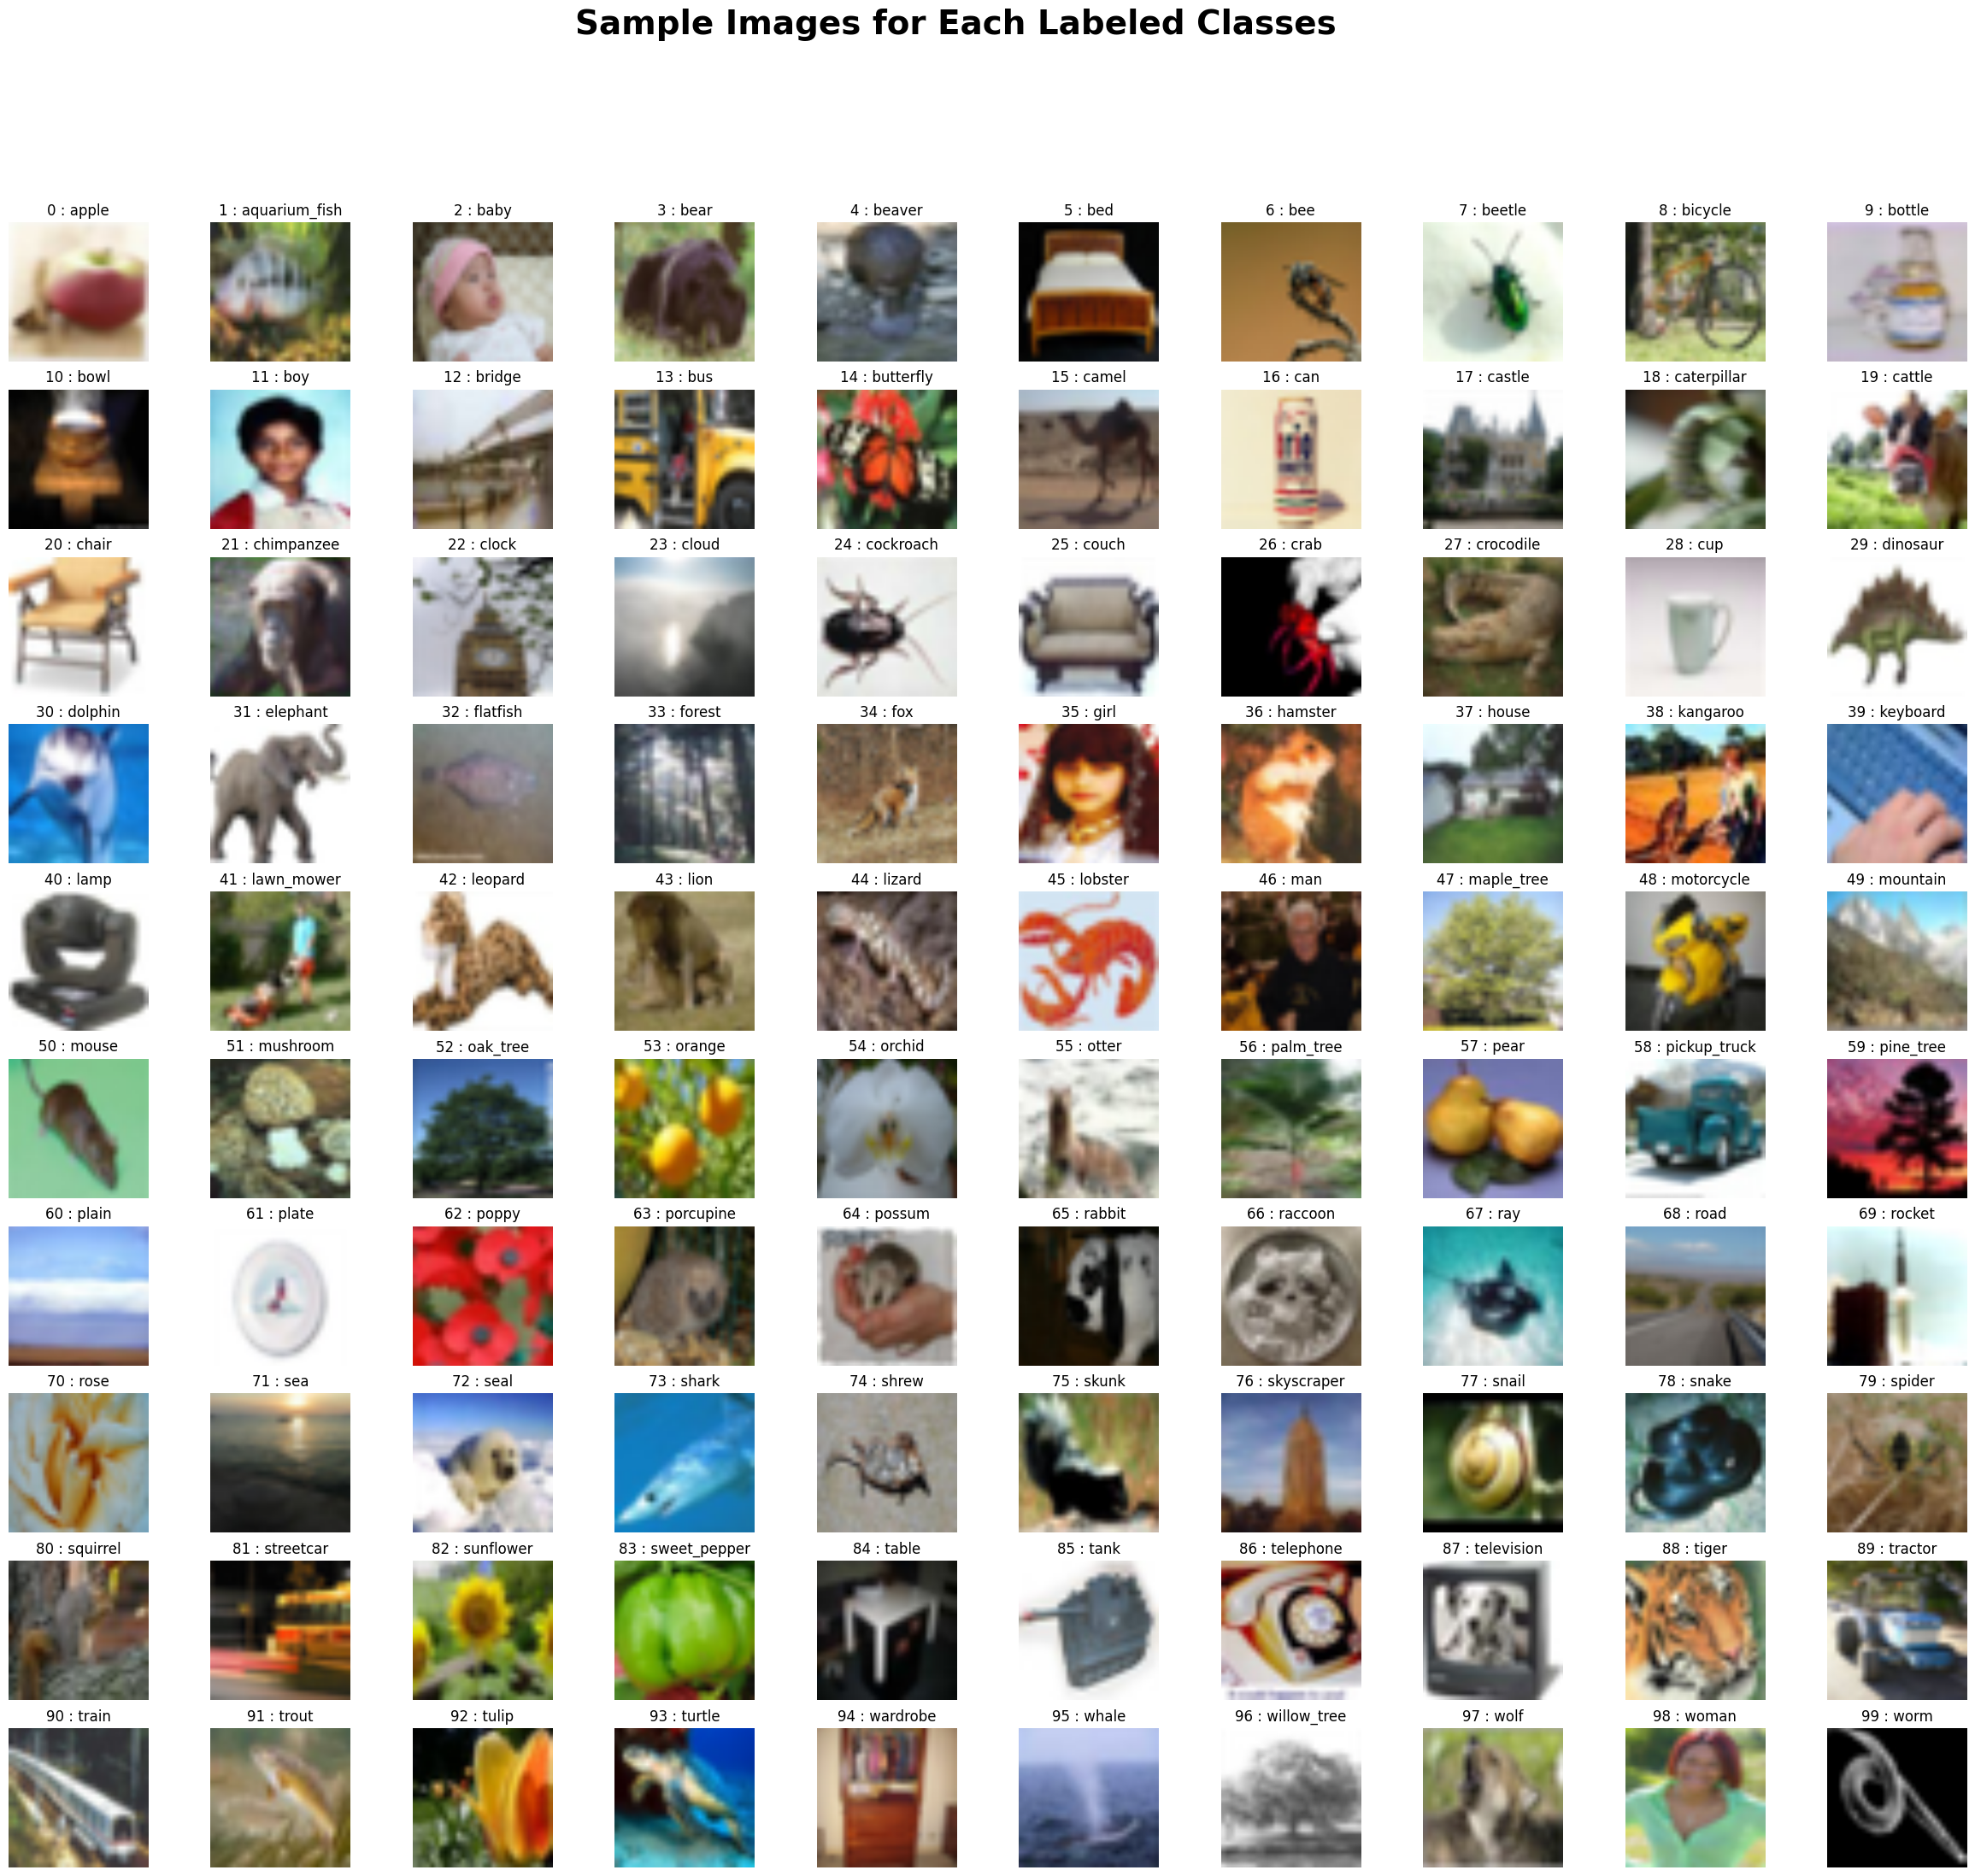

In [37]:
plotImages_Dataset(training_data, classLabel, nRows=10, nCols=10)

**07 -> Hyperparameters**

In [38]:
batch_size = 64
in_channels = 3  # image channel of a single image sample
img_width = 224  # img dimension after my_transforms
img_height = 224
num_classes = 100
learning_rate = 1e-4
epochs = 5
num_workers = 12

**08 -> Prepare dataloader and print some basic info on each dataset**

In [39]:
train_dataloader = DataLoader(training_data, batch_size=batch_size)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)

printInfo_DataLoader(train_dataloader, 'Training DataSet')
printInfo_DataLoader(valid_dataloader, 'Validating DataSet')

>>>  Training DataSet  <<<
Total Number of Samples: 50000
Total Number of Batches: 782
Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64
--------------------------------------------------
>>>  Validating DataSet  <<<
Total Number of Samples: 10000
Total Number of Batches: 157
Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64
--------------------------------------------------


**09 -> Setup Model and View Basic Layer Info**

In [40]:
model = Custom_VGG(vgg_types[0], in_channels=in_channels, nClasses=num_classes).to(device)
summary(model, (3,img_width, img_height), batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 224, 224]           1,792
       BatchNorm2d-2         [64, 64, 224, 224]             128
              ReLU-3         [64, 64, 224, 224]               0
         MaxPool2d-4         [64, 64, 112, 112]               0
            Conv2d-5        [64, 128, 112, 112]          73,856
       BatchNorm2d-6        [64, 128, 112, 112]             256
              ReLU-7        [64, 128, 112, 112]               0
         MaxPool2d-8          [64, 128, 56, 56]               0
            Conv2d-9          [64, 256, 56, 56]         295,168
      BatchNorm2d-10          [64, 256, 56, 56]             512
             ReLU-11          [64, 256, 56, 56]               0
           Conv2d-12          [64, 256, 56, 56]         590,080
      BatchNorm2d-13          [64, 256, 56, 56]             512
             ReLU-14          [64, 256,

**10 -> Loss function and optimizer setup**

In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**11 -> Train model under n epochs**

In [42]:
epoch_metrics, best_valid_loss = train_model_under_n_epochs(train_dataloader,
                                                           valid_dataloader,
                                                           epochs,
                                                           model,
                                                           loss_fn,
                                                           optimizer,
                                                           device)

 >>> Model Training with 5 epochs <<<
epoch: 0
batch#: 000 batch_loss: 4.655156  [   64/50000]
batch#: 100 batch_loss: 4.296331  [ 6464/50000]
batch#: 200 batch_loss: 4.068042  [12864/50000]
batch#: 300 batch_loss: 3.971490  [19264/50000]
batch#: 400 batch_loss: 3.807705  [25664/50000]
batch#: 500 batch_loss: 3.795303  [32064/50000]
batch#: 600 batch_loss: 3.707512  [38464/50000]
batch#: 700 batch_loss: 3.518970  [44864/50000]
batch#: 781 batch_loss: 3.340637  [50000/50000]
epoch 0  -> training and validation results
train_loss: 3.96123, train_acc: 8.636%
valid_loss: 3.37824, valid_acc: 18.133%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
epoch: 1
batch#: 000 batch_loss: 3.597172  [   64/50000]
batch#: 100 batch_loss: 3.328761  [ 6464/50000]
batch#: 200 batch_loss: 3.187888  [12864/50000]
batch#: 300 batch_loss: 3.134298  [19264/50000]
batch#: 400 batch_loss: 2.976158  [25664/50000]
batch#: 500 batch_loss: 2.997239  [32064/50000]
batch#: 600 batch_loss: 3.212694  [38464/50000]
ba

**References:**


1.  https://www.youtube.com/playlist?list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz
2.  https://www.baeldung.com/cs/convolutional-layer-size
3.  https://stackoverflow.com/questions/56450969/how-to-calculate-output-sizes-after-a-convolution-layer-in-a-configuration-file
4.  https://www.cs.toronto.edu/~kriz/cifar.html




